elapsed time for fitting is
1878.0341231822968


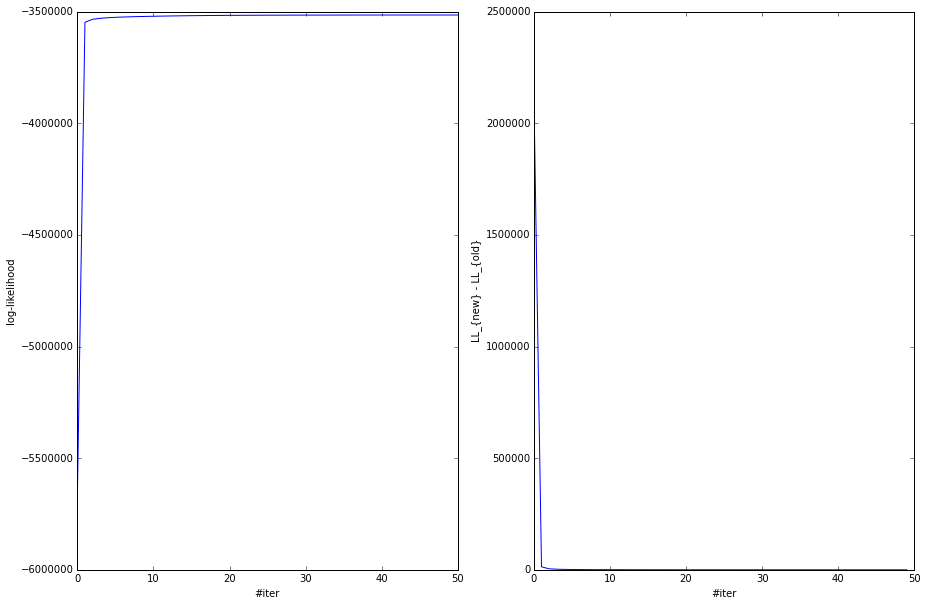

In [2]:
import numpy as np
import scipy as sp
import matplotlib
import matplotlib.pyplot as plt

import ssm_timeSeries as ts  # my self-written time series overhead
import ssm_fit               # my self-written library for state-space model fitting
import ssm_scripts

import random
from datetime import datetime     # generate random seed for 
random.seed(datetime.now())       # np.random. Once this is fixed, all 
rngSeed = random.randint(0, 1000) # other 'randomness' is also fixed

%matplotlib inline


yDim = 15
xDim = 5
uDim = 0

T = 100000
Trial = 1

#subpops = [list(range(0,yDim)), list(range(0,yDim))]
#obsTime = [int(T/2), T]
#obsPops = [1,0]

subpops = [list(range(0,yDim)), []]
obsPops = []
obsTime = []
for t in range(1,T+1):
    obsTime.append(t)
    if np.mod(t,2)==0:
        obsPops.append(0)
    elif np.mod(t,2)==1:
        obsPops.append(1)
#for t in range(1,int(T/2+1)):
#    obsTime.append(t)
#    if np.mod(t,2)==0:
#        obsPops.append(0)
#    elif np.mod(t,2)==1:
#        obsPops.append(1)
#obsTime.append(T)        
#obsPops.append(1)
    
obsScheme = {'subpops': subpops,
             'obsTime': obsTime,
             'obsPops': obsPops}

fitOptions = {'ifUseB' : False,  
              'maxIter': 50, 
              'ifPlotProgress' : True,
              'covConvEps' : 0,
              'ifTraceParamHist': False
             }

sf = '/home/mackelab/Desktop/Projects/Stitching/results/test_problems/LDS_save.mat'
[yOut,xOut,u,learnedPars,initPars,truePars] = ssm_scripts.run(xDim, yDim, uDim, T, obsScheme, fitOptions,saveFile=sf)



In [10]:
[A_0,B_0,Q_0,mu0_0, V0_0, C_0,d_0,R_0] = initPars
[A_h,B_h,Q_h,mu0_h, V0_h, C_h,d_h,R_h] = learnedPars
[A,B,Q,mu0, V0, C,d,R] = truePars

print(np.linalg.eig(A_0)[0])



[ 0.8751961   0.34130984  0.77311261  0.94072794  0.83902154]


In [52]:
import numpy as np
import scipy as sp
import matplotlib
import matplotlib.pyplot as plt
from scipy.io import savemat # store results for comparison with Matlab code   

import ssm_timeSeries as ts  # my self-written time series overhead
import ssm_fit               # my self-written library for state-space model fitting
import ssm_scripts

import random
from datetime import datetime     # generate random seed for 
random.seed(datetime.now())       # np.random. Once this is fixed, all 
rngSeed = random.randint(0, 1000) # other 'randomness' is also fixed

%matplotlib inline

yDim = 6
xDim = 3
uDim = 0

T = 10000
Trial = 1

subpops = [list(range(0,yDim)), []]
obsPops = []
obsTime = []
for t in range(1,T+1):
    obsTime.append(t)
    if np.mod(t,2)==0:
        obsPops.append(1)
    elif np.mod(t,2)==1:
        obsPops.append(0)
    
obsScheme = {'subpops': subpops,
             'obsTime': obsTime,
             'obsPops': obsPops}        
        
try:
    obsScheme['obsIdxG']     # check for addivional  
    obsScheme['idxgrps']     # (derivable) information
except:                       # can fill in if missing !
    [obsIdxG, idxgrps] = ssm_fit._computeObsIndexGroups(obsScheme,yDim)
    obsScheme['obsIdxG'] = obsIdxG # add index groups and 
    obsScheme['idxgrps'] = idxgrps # their occurences   

fitOptions = {'ifUseB' : False,  
              'maxIter': 50, 
              'ifPlotProgress' : True,
              'covConvEps' :0 
             }
pars = ssm_scripts.generatePars(xDim, yDim, uDim)
[x,y,u] = ssm_scripts.simulateExperiment(pars,T,Trial,obsScheme)
[A,B,Q,mu0, V0, C,d,R] = pars.copy()
Bu = np.zeros([A.shape[0], y.shape[1], y.shape[2]])

[A_0,B_0,Q_0,mu0_0, V0_0, C_0,d_0,R_0] = [A.copy(),B.copy(),Q.copy(),mu0.copy(), V0.copy(), C.copy(),d.copy(),R.copy()]
#A_0 *= 0.9
#Q_0 *= 1.6


no data model. Assuming data is given by real experiment or other external source
checking factorization of model ...
... factorization (locally) describes directed acyclic graph


In [53]:
[mu,V,P,Pinv,logc,tCovConvFt] = ssm_fit._KalmanFilter(A_0,Bu,Q_0,mu0_0,V0_0,C_0,d_0,R_0,y,obsScheme,eps=0)
[mu_h,V_h,J,tCovConvSm] = ssm_fit._KalmanSmoother(A_0, Bu, mu.copy(), V, P, Pinv, obsTime, tCovConvFt, eps=0)
[Ext, Extxt, Extxtm1]  = ssm_fit._KalmanParsToMoments(mu_h, V_h, J,obsTime,tCovConvFt,tCovConvSm)

In [54]:
[A_h,B_h,Q_h,mu0_h,V0_h,C_h,d_h,R_h,sy,syy,suu,suuinv,Ti] = ssm_fit._LDS_M_step(Ext, Extxt, Extxtm1, y, u, obsScheme, 
                 sy=None, syy=None, suu=None, suuinv=None, Ti=None)

In [55]:
print(A_0)
print(A_h)
print(A)

[[ 0.71779081 -0.47766039 -0.68528701]
 [ 0.05981419  1.02879174  0.10549889]
 [ 0.03104566  0.10135279  1.10191744]]
[[ 0.71760047 -0.47807002 -0.68580671]
 [ 0.05917536  1.02758608  0.10384843]
 [ 0.030637    0.09978039  1.1004071 ]]
[[ 0.71779081 -0.47766039 -0.68528701]
 [ 0.05981419  1.02879174  0.10549889]
 [ 0.03104566  0.10135279  1.10191744]]


In [56]:
print(Q_0)
print(Q_h)
print(Q)

[[ 0.5  0.   0. ]
 [ 0.   0.5  0. ]
 [ 0.   0.   0.5]]
[[  4.99937786e-01  -1.58306127e-04  -2.19939544e-04]
 [ -1.58306127e-04   4.99550029e-01  -5.81608138e-04]
 [ -2.19939542e-04  -5.81608140e-04   4.99128315e-01]]
[[ 0.5  0.   0. ]
 [ 0.   0.5  0. ]
 [ 0.   0.   0.5]]


In [31]:
i = 96
print('J[0,0,i,0]')
print(J[:,:,i,0])
print('V[0,0,i+1,0]')
print(V[:,:,i+1,0])
print('P[0,0,i,0]')
print(P[:,:,i,0])
print('V[0,0,i,0]')
print(V_h[:,:,i,0])
print('V_[0,0,i,0]?')
print(np.dot(J[:,:,i,0], np.dot(V_h[:,:,i+1,0]-P[:,:,i,0], J[:,:,i,0].transpose())) + V[:,:,i,0])
      

J[0,0,i,0]
[[ 0.59210942 -0.00897686]
 [ 0.00102706  0.52226695]]
V[0,0,i+1,0]
[[ 1.18250468 -0.0041665 ]
 [-0.0041665   0.95317981]]
P[0,0,i,0]
[[ 1.24039986 -0.00825759]
 [-0.00825759  1.11428269]]
V[0,0,i,0]
[[ 1.20233394 -0.00489781]
 [-0.00489781  1.03123565]]
V_[0,0,i,0]?
[[ 1.20233394 -0.00489781]
 [-0.00489781  1.03123565]]


In [37]:
i = 93
print(Extxtm1[:,:,i,0])
print(np.dot(V_h[:,:,i,0], J[:,:,i-1,0].transpose()) + np.outer(Ext[:,i,0],Ext[:,i-1,0]))

[[ 1.08246649 -0.06186843]
 [-0.05786525  0.49975021]]
[[ 1.08246649 -0.06186843]
 [-0.05786525  0.49975021]]


In [14]:
i = 73
print(J[:,:,i,0])
print(np.dot(np.dot(V[:,:,i,0], A_0.transpose()), sp.linalg.inv(P[:,:,i,0])))
      

[[ 0.57867963 -0.00813537]
 [ 0.0016417   0.477408  ]]
[[ 0.57867963 -0.00813537]
 [ 0.0016417   0.477408  ]]


In [16]:
i = 7
print(P[:,:,i,0])
print(np.dot(A_0, np.dot(V[:,:,i,0], A_0.transpose())) + Q_0)

[[ 1.2250507  -0.007139  ]
 [-0.007139    1.07790277]]
[[ 1.2250507  -0.007139  ]
 [-0.007139    1.07790277]]


In [19]:
i = 39
print(mu_h[:,i,0])
print(mu[:,i,0] + np.dot(J[:,:,i,0], mu_h[:,i+1,0]-np.dot(A_0,mu[:,i,0])))



[ 0.24377933  0.26387999]
[ 0.24377933  0.26387999]


In [24]:
i = 30
print(V[:,:,i,0])
print(P[:,:,i-1,0])

[[ 1.22509356 -0.00714214]
 [-0.00714214  1.07790417]]
[[ 1.22509356 -0.00714214]
 [-0.00714214  1.07790417]]


In [28]:
i = 78
print(mu[:,i,0])
print(np.dot(A_0,mu[:,i-1,0]))


[ 0.38531438 -0.13316378]
[ 0.38531438 -0.13316378]
